In [10]:
import os
import json
import math
import glob
import numpy as np
import xarray as xr
import geopandas as gpd

import cartopy.crs as ccrs

from multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

## This code Compare the results of downscale using differents neighborhoods

In [42]:
product, time_reso = 'IMERG', '3h'
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'SM2RAIN', '1dy'

In [43]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [44]:
if product == 'SM2RAIN':
    yy_s, yy_e = 2007, 2012
    year_vector = np.arange(yy_s, yy_e+1)
else:
    yy_s, yy_e = 2002, 2012
    year_vector = np.arange(yy_s, yy_e+1)

years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

print(f'Year Start: {yy_s}')
print(f'Year End  : {yy_e}')

Year Start: 2002
Year End  : 2012


In [45]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

print(f'Read json file   : {json_read.split('/')[-1]}')

Read json file   : IMERG_3h.json


In [46]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [47]:
BETA_list = glob.glob(os.path.join(dir_base,'1_BETA',f'*{product}_{time_reso}_{yy_s}_{yy_e}*.nc'))
BETA_list = sorted(BETA_list)
BETA_len = len(BETA_list)
BETA_list

['/media/arturo/Arturo/Data/Italy/Satellite/1_BETA/VENETO_BETA_IMERG_3h_2002_2012_npix_3.nc',
 '/media/arturo/Arturo/Data/Italy/Satellite/1_BETA/VENETO_BETA_IMERG_3h_2002_2012_npix_5.nc',
 '/media/arturo/Arturo/Data/Italy/Satellite/1_BETA/VENETO_BETA_IMERG_3h_2002_2012_npix_7.nc']

In [48]:
GAMMA_list = glob.glob(os.path.join(dir_base,'2_GAMMA',f'*{product}_{time_reso}_{yy_s}_{yy_e}*.nc'))
GAMMA_list = sorted(GAMMA_list)
GAMMA_len = len(GAMMA_list)
GAMMA_list

['/media/arturo/Arturo/Data/Italy/Satellite/2_GAMMA/VENETO_GAMMA_IMERG_3h_2002_2012_npix_3.nc',
 '/media/arturo/Arturo/Data/Italy/Satellite/2_GAMMA/VENETO_GAMMA_IMERG_3h_2002_2012_npix_5.nc',
 '/media/arturo/Arturo/Data/Italy/Satellite/2_GAMMA/VENETO_GAMMA_IMERG_3h_2002_2012_npix_7.nc']

In [49]:
DOWN_list = glob.glob(os.path.join(dir_base,'3_DOWN',f'*{product}_{time_reso}_{yy_s}_{yy_e}*.nc'))
DOWN_list = sorted(DOWN_list)
DOWN_len = len(DOWN_list)
DOWN_list

['/media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_IMERG_3h_2002_2012_npix_3.nc',
 '/media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_IMERG_3h_2002_2012_npix_5.nc',
 '/media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_IMERG_3h_2002_2012_npix_7.nc']

In [50]:
DATA = xr.open_dataset(BETA_list[0])
lat = DATA.lat.values
lon = DATA.lon.values
lon2d, lat2d = np.meshgrid(lon ,lat)

## BETA

In [51]:
BETA = np.zeros([3, len(lat), len(lon)])
for nn in range(3):
    DATA = xr.open_dataset(BETA_list[nn])
    BETA[nn,:,:] = DATA.BETA.values

## GAMMA

In [52]:
GAMMA = np.zeros([3, len(lat), len(lon)])
for nn in range(3):
    DATA = xr.open_dataset(GAMMA_list[nn])
    GAMMA[nn,:,:] = DATA.GAMMA.values

In [53]:
Letters_titles = ['(a)', '(b)', '(c)']
resolution_titles = ['3x3', '5x5', '7x7']

BETA_min = np.round(np.nanmin(BETA, axis=(0,1,2)),2)
BETA_max = np.round(np.nanmax(BETA, axis=(0,1,2)),2)
print(f'BETA limits: {BETA_min} and {BETA_max}')

GAMMA_min = np.round(np.nanmin(GAMMA, axis=(0,1,2)),2)
GAMMA_max = np.round(np.nanmax(GAMMA, axis=(0,1,2)),2)
print(f'GAMMA limits: {GAMMA_min} and {GAMMA_max}')

BETA limits: 1.05 and 1.27
GAMMA limits: 0.96 and 1.0


In [54]:
if product == 'IMERG':
    beta_lvl = np.arange(BETA_min,BETA_max+0.01,0.01)
    beta_norm = mcolors.BoundaryNorm(boundaries=beta_lvl, ncolors=256)

    gamma_lvl = np.arange(GAMMA_min,GAMMA_max,0.005)
    gamma_norm = mcolors.BoundaryNorm(boundaries=gamma_lvl, ncolors=256)

else:
    beta_norm = None
    gamma_norm = None

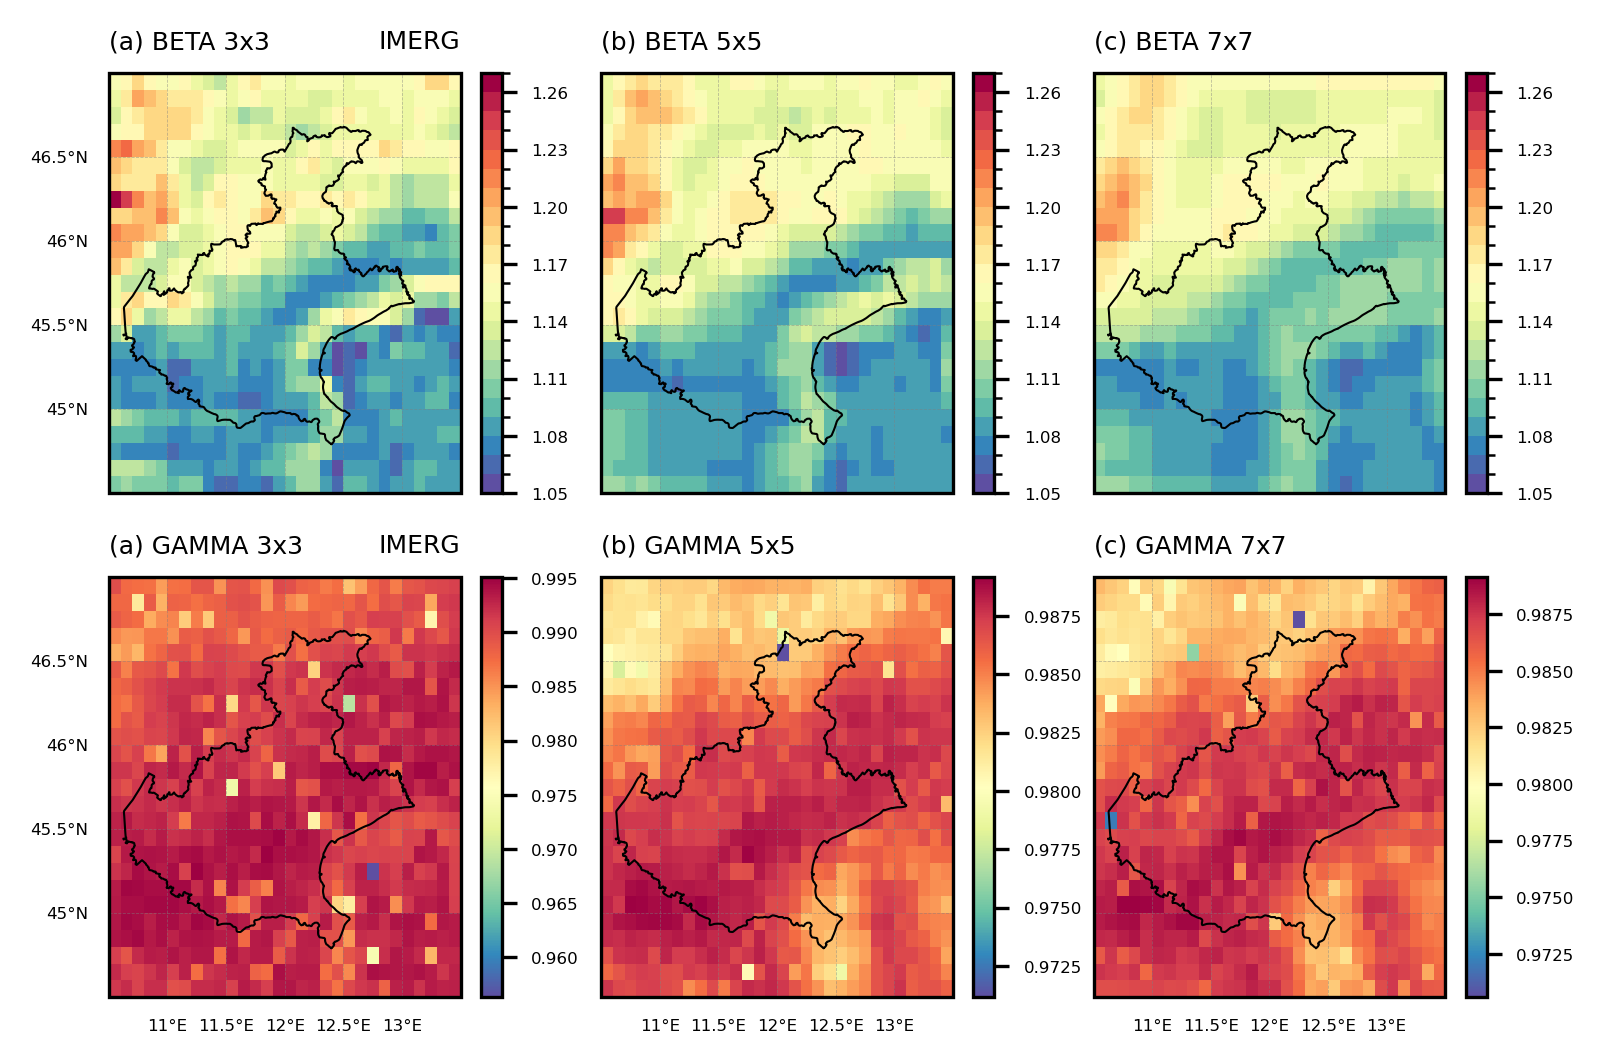

In [55]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
for ncol in range(3):
    ax1 = plt.subplot(gs[0, ncol], projection = proj)
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
    VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
    a1 = ax1.pcolormesh(lon2d, lat2d, BETA[ncol,:,:], cmap=cmap, norm=beta_norm)

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    if ncol == 1 or ncol == 2:
        gl.left_labels = False
    else:
        gl.left_labels = True
        ax1.set_title(product, fontsize=6, loc='right')
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    cbar = plt.colorbar(a1, fraction=0.053)
    cbar.ax.tick_params(labelsize=4)

    ax1.set_title(f'{Letters_titles[ncol]} BETA {resolution_titles[ncol]}', fontsize=6, loc='left')

# ==============================================================================
# ==============================================================================
for ncol in range(3):
    ax1 = plt.subplot(gs[1, ncol], projection = proj)
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
    VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
    a1 = ax1.pcolormesh(lon2d, lat2d, GAMMA[ncol,:,:], cmap=cmap, norm=None)

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    if ncol == 1 or ncol == 2:
        gl.left_labels = False
    else:
        gl.left_labels = True
        ax1.set_title(product, fontsize=6, loc='right')
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    cbar = plt.colorbar(a1, fraction=0.053)
    cbar.ax.tick_params(labelsize=4)

    ax1.set_title(f'{Letters_titles[ncol]} GAMMA {resolution_titles[ncol]}', fontsize=6, loc='left')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## Load Downscaling Parameters

In [56]:
DATA = xr.open_dataset(DOWN_list[0])
years = DATA.year.values
Tr = DATA.Tr.values
tr = 2
print(f'Return time: {Tr[tr]} years')

Return time: 50 years


In [57]:
DOWN_list[nn]

'/media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_IMERG_3h_2002_2012_npix_7.nc'

In [58]:
Nd = np.zeros([3,len(years), len(lat), len(lon)])
Cd = np.zeros([3,len(years), len(lat), len(lon)])
Wd = np.zeros([3,len(years), len(lat), len(lon)])
Quantile50 = np.zeros([3,len(Tr), len(lat), len(lon)])
Quantile100 = np.zeros([3,len(Tr), len(lat), len(lon)])
for nn in range(3):
    print(f'Read file: {DOWN_list[nn]}')
    DATA = xr.open_dataset(DOWN_list[nn])
    Nd[nn,:,:,:] = DATA.Nd.values
    Cd[nn,:,:,:] = DATA.Cd.values
    Wd[nn,:,:,:] = DATA.Wd.values
    Quantile50[nn,:,:,:] = DATA.Quantile.values[2,:,:]
    Quantile100[nn,:,:,:] = DATA.Quantile.values[3,:,:]

Read file: /media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_IMERG_3h_2002_2012_npix_3.nc
Read file: /media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_IMERG_3h_2002_2012_npix_5.nc
Read file: /media/arturo/Arturo/Data/Italy/Satellite/3_DOWN/VENETO_DOWN_IMERG_3h_2002_2012_npix_7.nc


In [61]:
print(np.nanmax(Nd[0,:,:,:],axis=(0,1,2)))
print(np.nanmax(Nd[1,:,:,:],axis=(0,1,2)))
print(np.nanmax(Nd[2,:,:,:],axis=(0,1,2)))

218.0
215.0
217.0


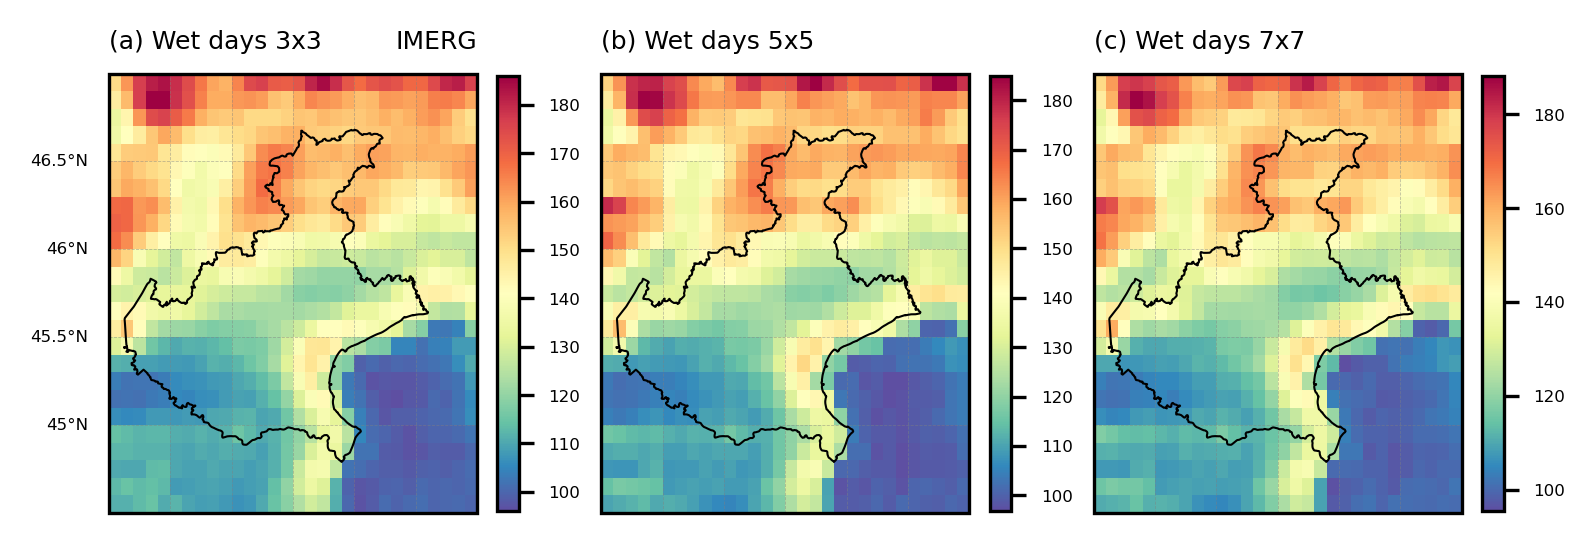

In [60]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
# ==============================================================================
for ncol in range(3):
    ax1 = plt.subplot(gs[0, ncol], projection = proj)
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
    VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
    a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Nd[ncol,:,:,:],axis=0), cmap=cmap, norm=None)

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    if ncol == 1 or ncol == 2:
        gl.left_labels = False
    else:
        gl.left_labels = True
        ax1.set_title(product, fontsize=6, loc='right')
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    cbar = plt.colorbar(a1, fraction=0.053)
    cbar.ax.tick_params(labelsize=4)

    ax1.set_title(f'{Letters_titles[ncol]} Wet days {resolution_titles[ncol]}', fontsize=6, loc='left')


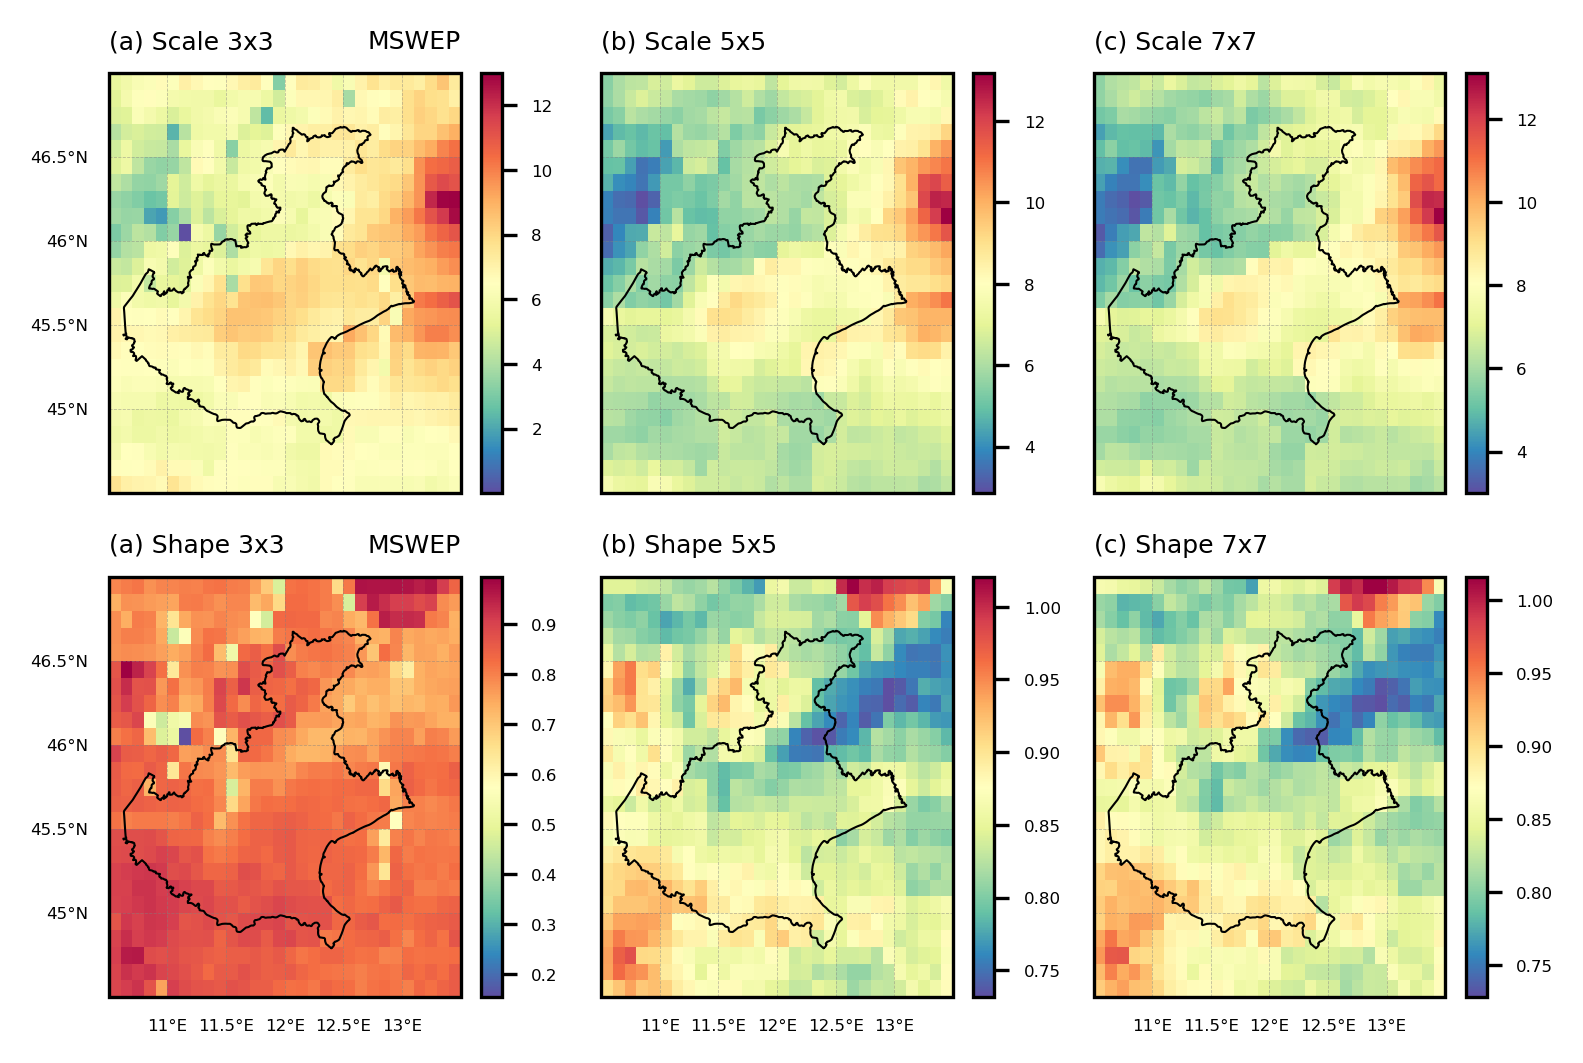

In [ ]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
for ncol in range(3):
    ax1 = plt.subplot(gs[0, ncol], projection = proj)
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
    VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
    a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Cd[ncol,:,:,:],axis=0), cmap=cmap, norm=None)

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    if ncol == 1 or ncol == 2:
        gl.left_labels = False
    else:
        gl.left_labels = True
        ax1.set_title(product, fontsize=6, loc='right')
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    cbar = plt.colorbar(a1, fraction=0.053)
    cbar.ax.tick_params(labelsize=4)

    ax1.set_title(f'{Letters_titles[ncol]} Scale {resolution_titles[ncol]}', fontsize=6, loc='left')

# ==============================================================================
# ==============================================================================
for ncol in range(3):
    ax1 = plt.subplot(gs[1, ncol], projection = proj)
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
    VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
    a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(Wd[ncol,:,:,:],axis=0), cmap=cmap, norm=None)

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    if ncol == 1 or ncol == 2:
        gl.left_labels = False
    else:
        gl.left_labels = True
        ax1.set_title(product, fontsize=6, loc='right')
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    cbar = plt.colorbar(a1, fraction=0.053)
    cbar.ax.tick_params(labelsize=4)

    ax1.set_title(f'{Letters_titles[ncol]} Shape {resolution_titles[ncol]}', fontsize=6, loc='left')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [20]:
Q50_min = np.round(np.nanmin(Quantile50[:,2,:,:], axis=(0,1,2)),2)
Q50_max = np.round(np.nanmax(Quantile50[:,2,:,:], axis=(0,1,2)),2)
print(f'Q50 limits: {Q50_min} and {Q50_max}')

Q100_min = np.round(np.nanmin(Quantile100[:,3,:,:], axis=(0,1,2)),2)
Q100_max = np.round(np.nanmax(Quantile100[:,3,:,:], axis=(0,1,2)),2)
print(f'Q100 limits: {Q100_min} and {Q100_max}')

Q50 limits: 39.38 and 4142.09
Q100 limits: 43.41 and 6958.66


In [21]:
if product == 'IMERG':
    Q50_lvl = np.arange(120,520,20)
    Q50_norm = mcolors.BoundaryNorm(boundaries=Q50_lvl, ncolors=256)

    Q100_lvl = np.arange(140,590,20)
    Q100_norm = mcolors.BoundaryNorm(boundaries=Q100_lvl, ncolors=256)

else:
    Q50_norm = None
    Q100_norm = None

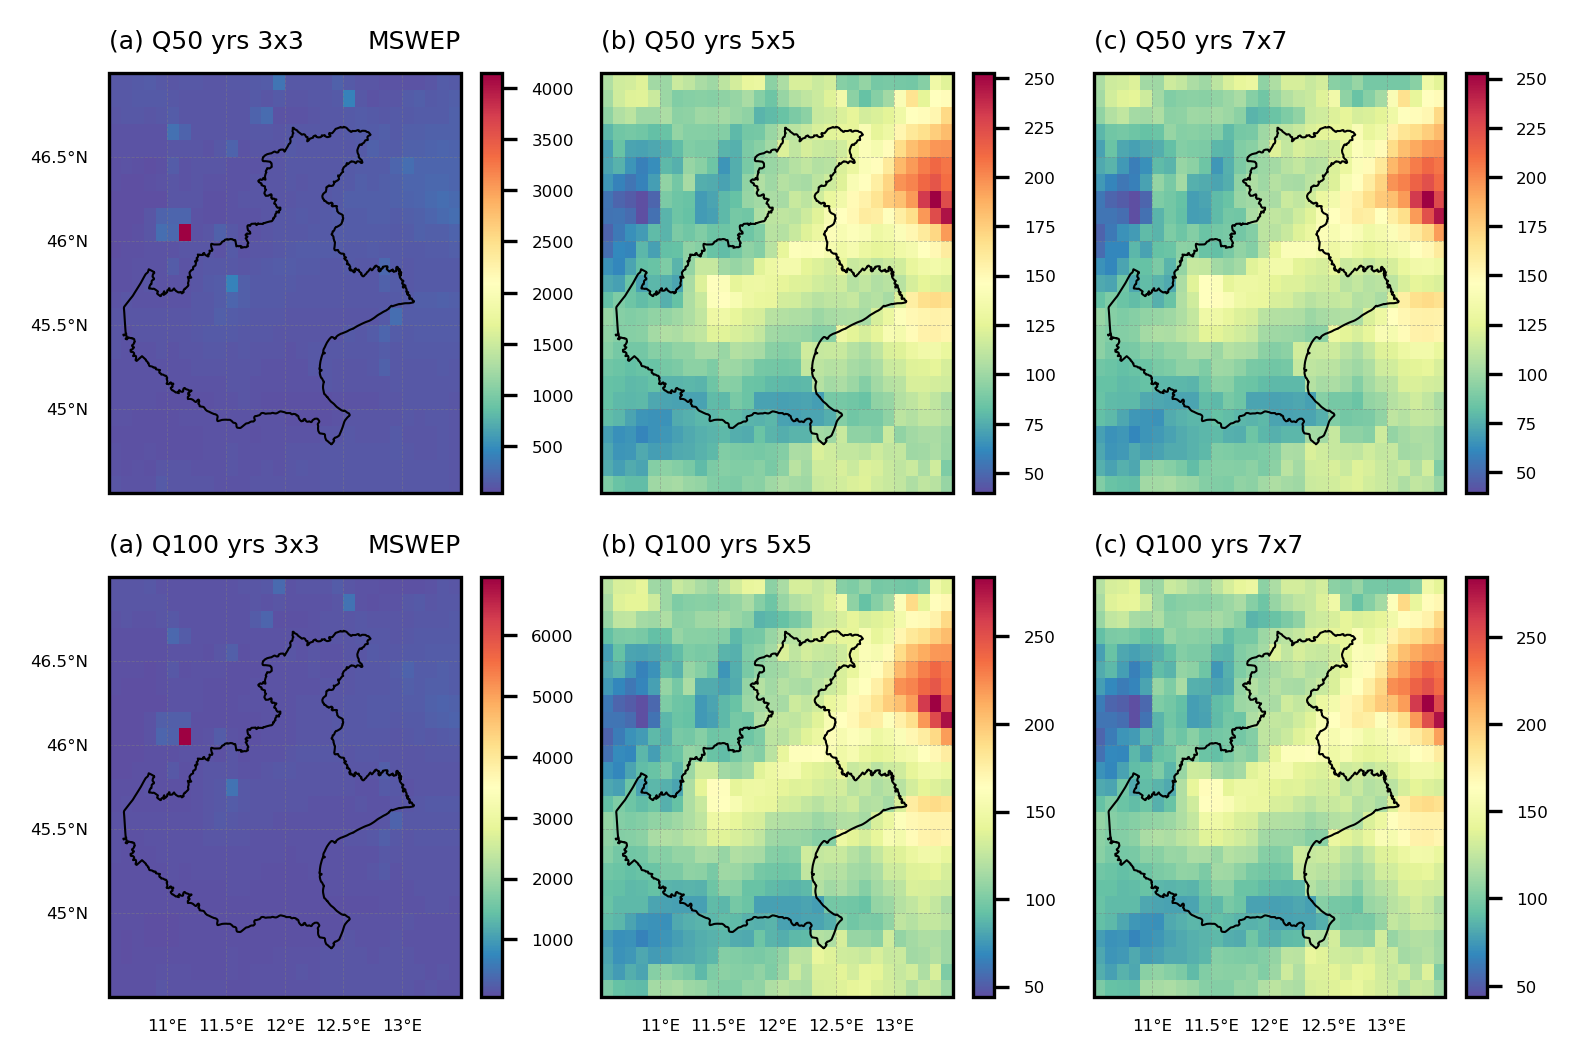

In [22]:

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
for ncol in range(3):
    ax1 = plt.subplot(gs[0, ncol], projection = proj)
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
    VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
    a1 = ax1.pcolormesh(lon2d, lat2d, Quantile50[ncol,2,:,:], cmap=cmap, norm=Q50_norm)

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    if ncol == 1 or ncol == 2:
        gl.left_labels = False
    else:
        gl.left_labels = True
        ax1.set_title(product, fontsize=6, loc='right')
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    cbar = plt.colorbar(a1, fraction=0.053)
    cbar.ax.tick_params(labelsize=4)

    ax1.set_title(f'{Letters_titles[ncol]} Q50 yrs {resolution_titles[ncol]}', fontsize=6, loc='left')

# ==============================================================================
# ==============================================================================
for ncol in range(3):
    ax1 = plt.subplot(gs[1, ncol], projection = proj)
    ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
    VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
    a1 = ax1.pcolormesh(lon2d, lat2d, Quantile100[ncol,3,:,:], cmap=cmap, norm=Q100_norm)

    gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    if ncol == 1 or ncol == 2:
        gl.left_labels = False
    else:
        gl.left_labels = True
        ax1.set_title(product, fontsize=6, loc='right')
    gl.xlabel_style = {'size': 4, 'color': 'k'}
    gl.ylabel_style = {'size': 4, 'color': 'k'}

    cbar = plt.colorbar(a1, fraction=0.053)
    cbar.ax.tick_params(labelsize=4)

    ax1.set_title(f'{Letters_titles[ncol]} Q100 yrs {resolution_titles[ncol]}', fontsize=6, loc='left')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

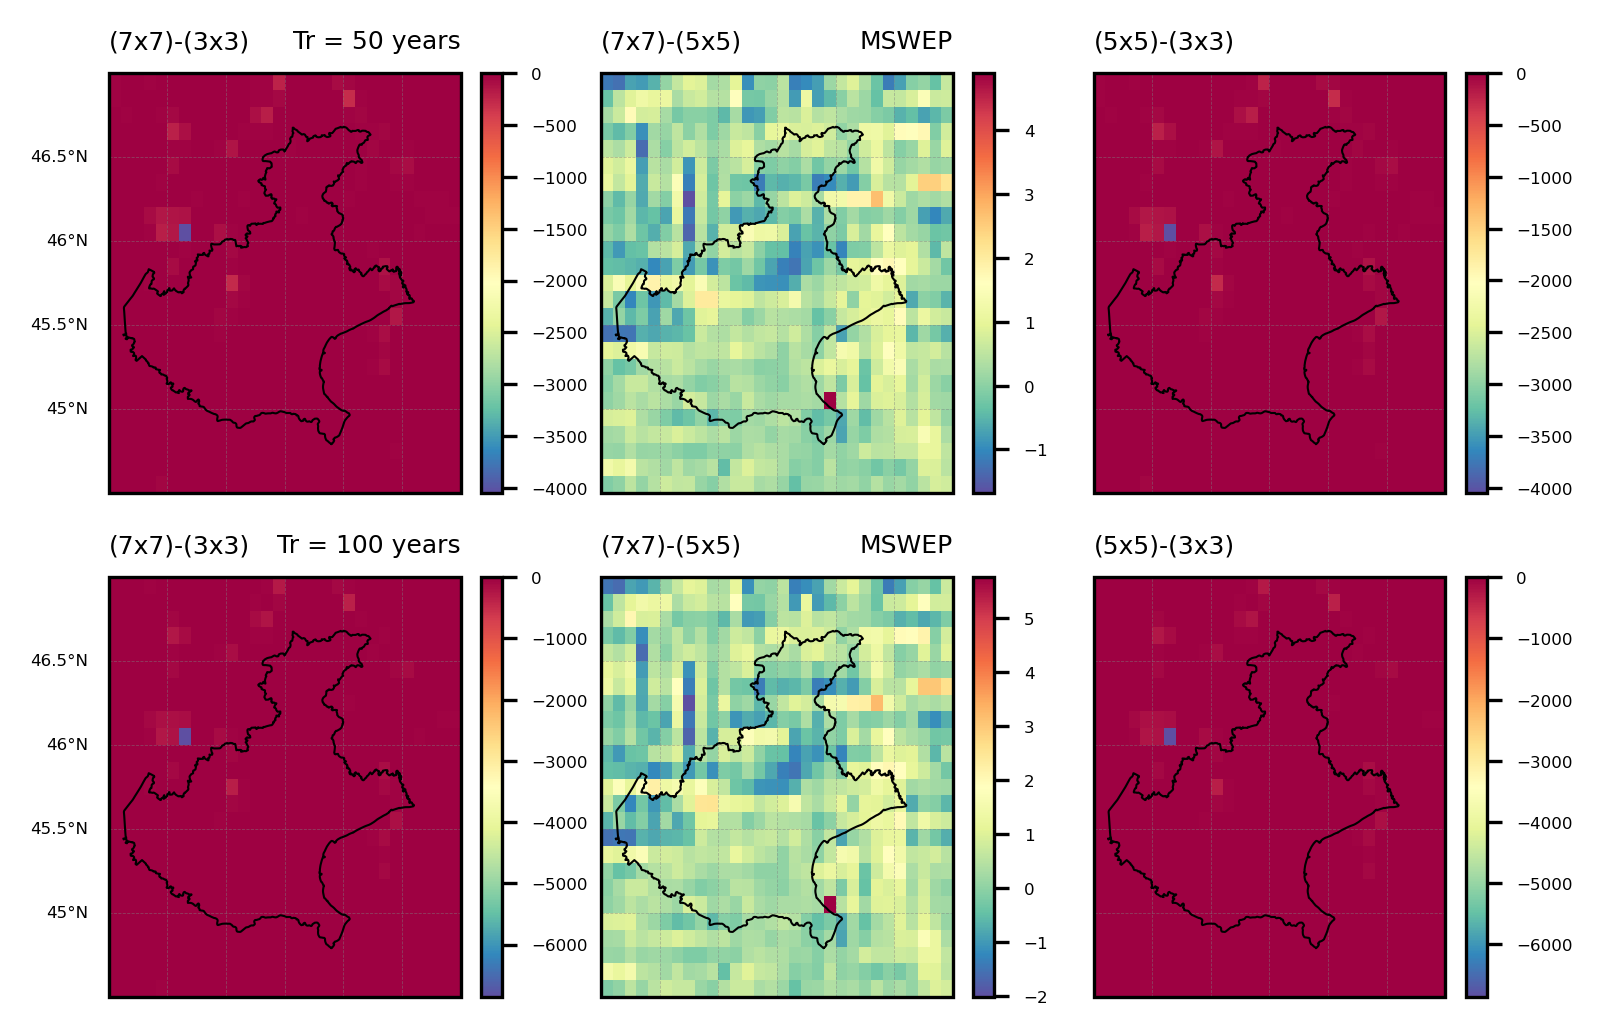

In [23]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, Quantile50[2,3,:,:] - Quantile50[0,3,:,:], cmap=cmap, norm=None)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(7x7)-(3x3)', fontsize=6, loc='left')
ax1.set_title('Tr = 50 years', fontsize=6, loc='right')

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, Quantile50[2,3,:,:] - Quantile50[1,3,:,:], cmap=cmap, norm=None)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(7x7)-(5x5)', fontsize=6, loc='left')
ax1.set_title(product, fontsize=6, loc='right')

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, Quantile50[1,3,:,:] - Quantile50[0,3,:,:], cmap=cmap, norm=None)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(5x5)-(3x3)', fontsize=6, loc='left')

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, Quantile100[2,3,:,:] - Quantile100[0,3,:,:], cmap=cmap, norm=None)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(7x7)-(3x3)', fontsize=6, loc='left')
ax1.set_title('Tr = 100 years', fontsize=6, loc='right')

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, Quantile100[2,3,:,:] - Quantile100[1,3,:,:], cmap=cmap, norm=None)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(7x7)-(5x5)', fontsize=6, loc='left')
ax1.set_title(product, fontsize=6, loc='right')

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', linewidth=0.5, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, Quantile100[1,3,:,:] - Quantile100[0,3,:,:], cmap=cmap, norm=None)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(5x5)-(3x3)', fontsize=6, loc='left')

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

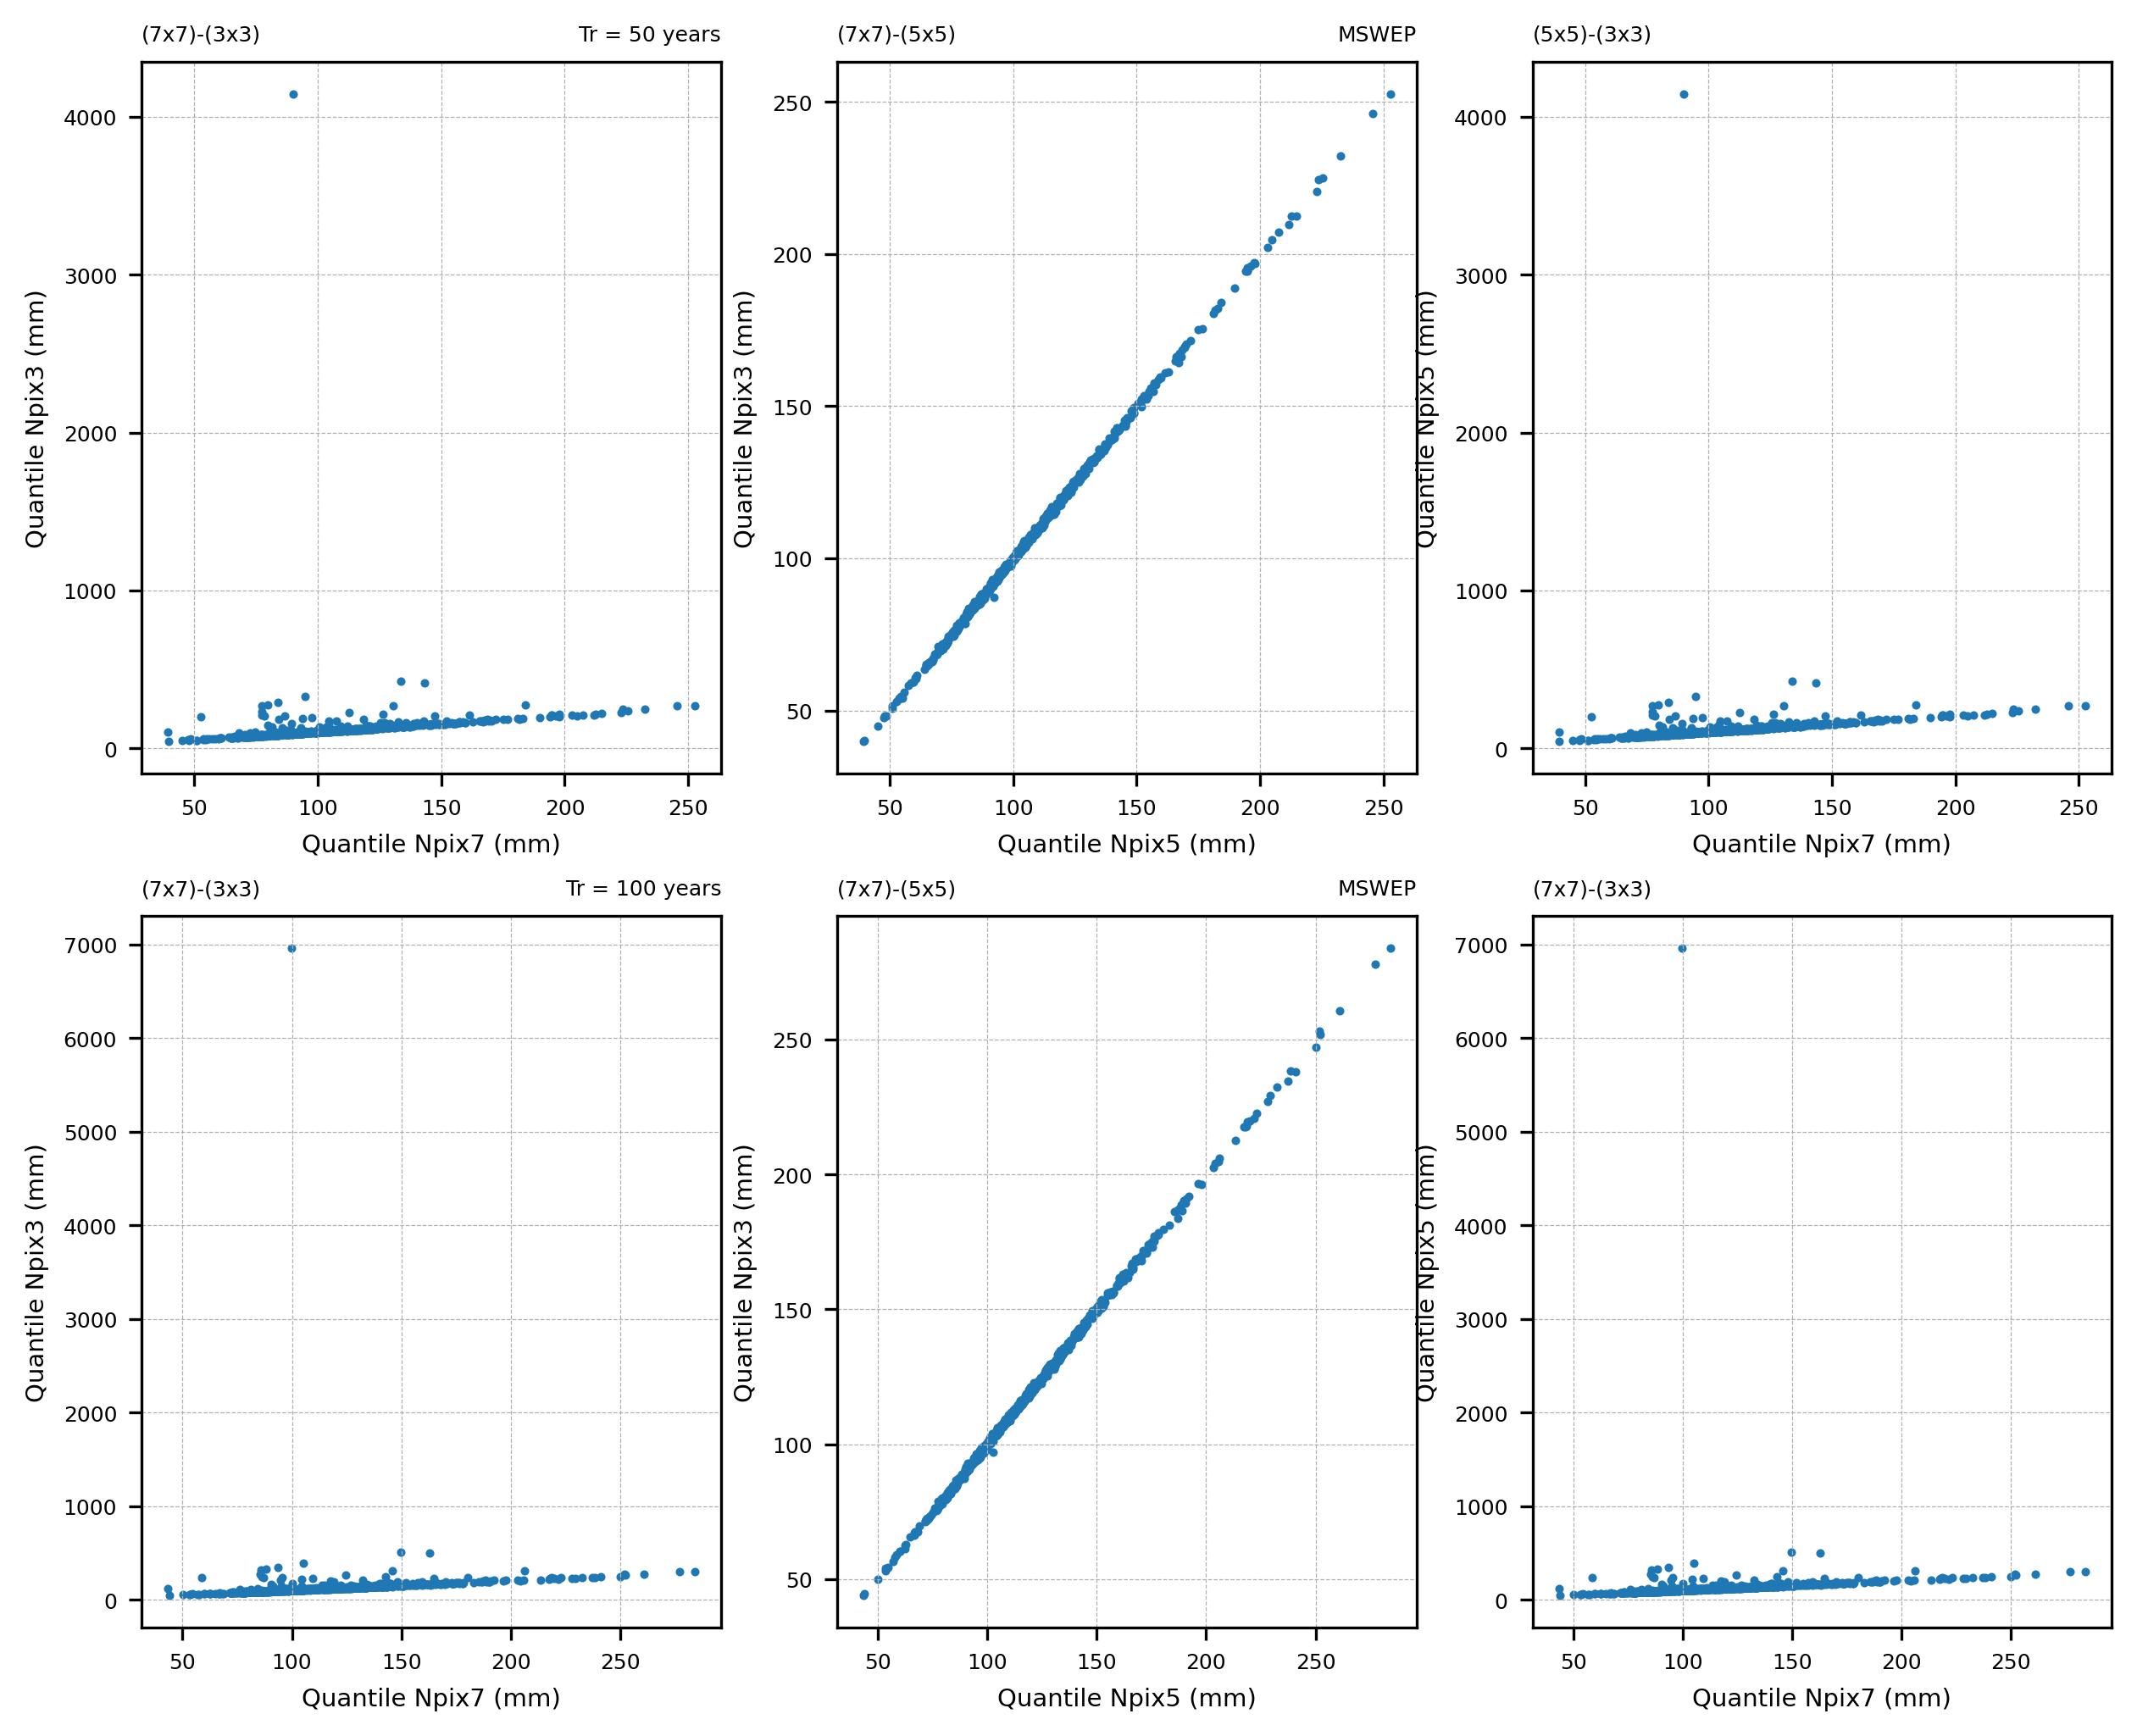

In [24]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(Quantile50[2,3,:,:].flatten(), 
            Quantile50[0,3,:,:].flatten(), 
            s=2, label='Scatter points')

ax1.set_title('(7x7)-(3x3)', fontsize=6, loc='left')
ax1.set_title('Tr = 50 years', fontsize=6, loc='right')

ax1.set_xlabel('Quantile Npix7 (mm)', fontsize=7)
ax1.set_ylabel('Quantile Npix3 (mm)', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(Quantile50[2,3,:,:].flatten(), 
            Quantile50[1,3,:,:].flatten(), 
            s=2, label='Scatter points')

ax1.set_title('(7x7)-(5x5)', fontsize=6, loc='left')
ax1.set_title(product, fontsize=6, loc='right')

ax1.set_xlabel('Quantile Npix5 (mm)', fontsize=7)
ax1.set_ylabel('Quantile Npix3 (mm)', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(Quantile50[2,3,:,:].flatten(), 
            Quantile50[0,3,:,:].flatten(), 
            s=2, label='Scatter points')

ax1.set_title('(5x5)-(3x3)', fontsize=6, loc='left')

ax1.set_xlabel('Quantile Npix7 (mm)', fontsize=7)
ax1.set_ylabel('Quantile Npix5 (mm)', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.scatter(Quantile100[2,3,:,:].flatten(), 
            Quantile100[0,3,:,:].flatten(), 
            s=2, label='Scatter points')

ax1.set_title('(7x7)-(3x3)', fontsize=6, loc='left')
ax1.set_title('Tr = 100 years', fontsize=6, loc='right')

ax1.set_xlabel('Quantile Npix7 (mm)', fontsize=7)
ax1.set_ylabel('Quantile Npix3 (mm)', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.scatter(Quantile100[2,3,:,:].flatten(), 
            Quantile100[1,3,:,:].flatten(), 
            s=2, label='Scatter points')

ax1.set_title('(7x7)-(5x5)', fontsize=6, loc='left')
ax1.set_title(product, fontsize=6, loc='right')

ax1.set_xlabel('Quantile Npix5 (mm)', fontsize=7)
ax1.set_ylabel('Quantile Npix3 (mm)', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')


# ==============================================================================
ax1 = plt.subplot(gs[1, 2])
ax1.scatter(Quantile100[2,3,:,:].flatten(), 
            Quantile100[0,3,:,:].flatten(), 
            s=2, label='Scatter points')

ax1.set_title('(7x7)-(3x3)', fontsize=6, loc='left')

ax1.set_xlabel('Quantile Npix7 (mm)', fontsize=7)
ax1.set_ylabel('Quantile Npix5 (mm)', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)